In [1]:
import config
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
%matplotlib inline

In [5]:
# This function shows an image
def show_image(image, findings):
    plt.imshow(image, cmap='gray')
    plt.title(f'Findinds: {findings}', loc='left')
    plt.axis('off')
    plt.show()
    
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data  
def check_dicom(filename):  
    print('\n\nLoad file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    img = ds.pixel_array
    
    modality = ds.Modality
    if modality != 'DX':
        print(f"{filename} -- file will not be processed.")
        print(f"{modality} imaging modality is not supported.")
        return None
    
    examined_part = ds.BodyPartExamined
    if examined_part != 'CHEST':
        print(f"{filename} -- file will not be processed.")
        print(f"{examined_part} not an appropriate body part.")
        return None
    
    patient_age = ds.PatientAge
    if not (1 <= int(patient_age) <= 95):
        print(f"{filename} -- file will not be processed.")
        print(f"{patient_age} not within the appropriate range of 1 to 95 years.")
        return None
        
    patient_position = ds.PatientPosition 
    if patient_position not in ['AP', 'PA']:
        print(f"{filename} -- file will not be processed.")
        print(f"{patient_position} -- Patient position must be AP or PA.")
        return None
    
    show_image(img, findings=ds.StudyDescription)
 
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_mean, img_std, img_size): 
    # todo
    proc_img = (img - img_mean) / img_std
    proc_img = resize(proc_img, img_size)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):

    with open(model_path, 'r') as json_file:
        model_json = json_file.read()

    model = tf.keras.models.model_from_json(model_json)
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    prediction = model.predict(img)
    prediction = prediction >= thresh
    return "Pneumonia" if prediction else "No pneumonia" 



Load file test1.dcm ...


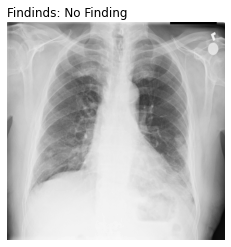

Prediction: Pneumonia


Load file test2.dcm ...


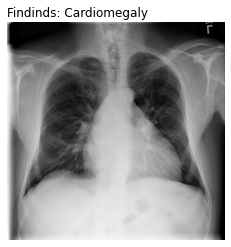

Prediction: Pneumonia


Load file test3.dcm ...


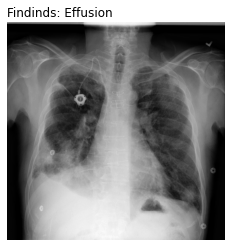

Prediction: Pneumonia


Load file test4.dcm ...
test4.dcm -- file will not be processed.
RIBCAGE not an appropriate body part.


Load file test5.dcm ...
test5.dcm -- file will not be processed.
CT imaging modality is not supported.


Load file test6.dcm ...
test6.dcm -- file will not be processed.
XX -- Patient position must be AP or PA.


In [6]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = config.model_path
weight_path = config.weight_path

img_size = config.input_size   # model input size
img_mean = config.img_mean    # loads the mean image value they used during training preprocessing
img_std = config.img_std     # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path)
thresh = config.best_thresh

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img, img_mean, img_std, img_size)
    pred = predict_image(my_model,img_proc,thresh)
    print(f'Prediction: {pred}')